In [10]:
from pathlib import Path
import random
import cv2, numpy as np, torch, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm
from scipy.ndimage import label as cc_label
import cv2
# === ПРАВЬ ЗДЕСЬ, если нужно ===
ROOT        = Path("/storage01/miroslavm/3d_segmentation_models/data_rat/mose_jpeg/")
CHECKPOINT  = Path("/storage01/miroslavm/3d_segmentation_models/seg_anything/sam2/checkpoints/sam2.1_hiera_base_plus.pt")
CFG_PATH    = "configs/sam2.1/sam2.1_hiera_b+.yaml"          # файл лежит в sam2/configs/
BATCH_SIZE  = 28
LR          = 1e-5
EPOCHS      = 200
VAL_FRAC    = 0.10          # 10 % валид.
DEVICE      = "cuda"        # или "cpu"
MODEL_SAVE  = Path("sam2.1_finetuned_b+.pt")
delta = 12
MODEL_DIR   = Path("./checkpoints")
MODEL_DIR.mkdir(exist_ok=True)
LAST_CKPT   = MODEL_DIR / "sam2_last.ckpt"      # «хвост»-чекпойнт (для resume)
BEST_CKPT   = MODEL_DIR / "sam2_best.pth" 

In [11]:

def augment(img: np.ndarray, msk: np.ndarray, pt: list | None):
    h, w = msk.shape

    # --- H-flip ----------------------------------------------------------
    if random.random() < 0.5:
        img, msk = img[:, ::-1], msk[:, ::-1]
        if pt is not None:
            pt[0] = w - 1 - pt[0]

    # --- V-flip ----------------------------------------------------------
    if random.random() < 0.5:
        img, msk = img[::-1, :], msk[::-1, :]
        if pt is not None:
            pt[1] = h - 1 - pt[1]

    # --- ±90° -----------------------------------------------------------
    if random.random() < 0.25:
        k = random.choice([1, 3])           # +90° or −90°
        img, msk = np.rot90(img, k), np.rot90(msk, k)
        if pt is not None:
            x, y = pt
            if k == 1:                      # +90°
                pt[:] = [y, w - 1 - x]
            else:                           # −90°
                pt[:] = [h - 1 - y, x]

    return np.ascontiguousarray(img), np.ascontiguousarray(msk), pt

In [12]:
CLAHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
def _preprocess_gray3(img_bgr: np.ndarray) -> np.ndarray:
    """
    → 3-канальное float32 изображение в диапазоне [0, 1]  
      * CLAHE повышает контраст;  
      * grayscale → RGB дубликат (SAM ждёт 3 канала).
    """
    if img_bgr.ndim == 2:               # гарантия на случай cv2.IMREAD_GRAYSCALE
        gray = img_bgr
    else:
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    gray_eq = CLAHE.apply(gray)
    rgb     = np.stack([gray_eq]*3, axis=-1)
    return (rgb.astype(np.float32) / 255.0)

In [13]:
import numpy as np, cv2
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
def split_touching_objects(bin_mask: np.ndarray,
                           min_peak_distance: int = 6,
                           min_obj_size: int = 40) -> np.ndarray:
    """
    Возвращает label-маску, где каждый слипшийся объект разделён.
    bin_mask : (H,W) uint8 {0,1}
    """
    dist = ndi.distance_transform_edt(bin_mask)
    peaks = peak_local_max(dist,
                           labels=bin_mask,
                           min_distance=min_peak_distance,
                           exclude_border=False)
    # если пиков нет – вернётся исходный компонент
    if len(peaks) == 0:
        lbl, _ = ndi.label(bin_mask)
        return lbl.astype(np.int32)

    markers = np.zeros_like(bin_mask, dtype=np.int32)
    for i, (y, x) in enumerate(peaks, 1):
        markers[y, x] = i
    labels = watershed(-dist, markers, mask=bin_mask)

    # фильтр микроскопических кусочков
    if min_obj_size > 0:
        sizes = ndi.sum_labels(np.ones_like(labels), labels,
                               index=np.arange(1, labels.max() + 1))
        for lbl_id, s in enumerate(sizes, 1):
            if s < min_obj_size:
                labels[labels == lbl_id] = 0
        labels, _ = ndi.label(labels > 0)

    return labels.astype(np.int32)

In [14]:

IMG_DIR  = ROOT / "images"
MSK_DIR  = ROOT / "masks"

assert IMG_DIR.exists() and MSK_DIR.exists(), "⛔ images/ или masks/ не найдены"

# def resize_and_pad(img, mask, target=1024):
#     h, w = img.shape[:2]
#     # коэффициент только если long_side > target
#     r = target / max(h, w) if max(h, w) > target else 1.0
#     if r != 1.0:
#         new_w, new_h = int(w * r), int(h * r)
#         img  = cv2.resize(img,  (new_w, new_h))
#         mask = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

#     # паддинг до target×target
#     pad_h, pad_w = target - img.shape[0], target - img.shape[1]
#     if pad_h or pad_w:
#         img  = np.pad(img,  ((0, pad_h), (0, pad_w), (0, 0)), constant_values=0)
#         mask = np.pad(mask, ((0, pad_h), (0, pad_w)),          constant_values=0)
#     return img, mask

class MoseDataset(Dataset):
    """
    Каждая связная компонента (после разделения watershed'ом) – отдельный sample.
    """
    def __init__(self, img_dir, msk_dir, neg_prompt=True,
                 peak_dist: int = 6, min_sz: int = 40):
        self.img_dir, self.msk_dir = Path(img_dir), Path(msk_dir)
        self.neg_prompt = neg_prompt
        self.peak_dist = peak_dist
        self.min_sz    = min_sz

        self.items = []   # [(img_name, comp_id), ...]

        for img_path in self.img_dir.glob("*.jpg"):
            name = img_path.stem
            msk_path = self.msk_dir / f"{name}.png"
            if not msk_path.exists():
                continue

            raw = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)
            if raw is None or raw.max() == 0:
                continue

            # ── разделяем компоненты ─────────────────────────────────────────
            lbl = split_touching_objects(raw > 0,
                                         min_peak_distance=self.peak_dist,
                                         min_obj_size=self.min_sz)
            for cid in range(1, lbl.max() + 1):
                self.items.append((name, cid))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        name, cid = self.items[idx]

        img_bgr = cv2.imread(str(self.img_dir / f"{name}.jpg"),
                             cv2.IMREAD_COLOR)
        img     = _preprocess_gray3(img_bgr)

        msk_raw = cv2.imread(str(self.msk_dir / f"{name}.png"),
                             cv2.IMREAD_GRAYSCALE)
        lbl = split_touching_objects(msk_raw > 0,
                                     min_peak_distance=self.peak_dist,
                                     min_obj_size=self.min_sz)
        msk = (lbl == cid).astype(np.float32)   # (H,W)

        # ── positive prompt --------------------------------------------------
        ys, xs = np.where(msk > 0)
        j = random.randrange(len(xs))
        pos_pt = [int(xs[j]), int(ys[j])]

        pts, labs = [pos_pt], [1.]
        if self.neg_prompt:
            h, w = msk.shape
            nx, ny = random.randrange(w), random.randrange(h)
            while msk[ny, nx]:
                nx, ny = random.randrange(w), random.randrange(h)
            pts.append([nx, ny]); labs.append(0.)

        img, msk, pos_pt = augment(img, msk, pos_pt)

        return {
            "image": img.copy(),                          # np.ndarray
            "mask" : torch.from_numpy(msk).unsqueeze(0),  # (1,H,W)
            "point": torch.tensor(pts,  dtype=torch.float32),
            "label": torch.tensor(labs, dtype=torch.float32)
        }

In [15]:
from torch.utils.data.dataloader import default_collate
def pad_reflect(img, msk, pts, max_h, max_w):
    h, w = img.shape[:2]
    ph, pw = max_h - h, max_w - w
    top, bot   = ph // 2, ph - ph // 2
    left, right = pw // 2, pw - pw // 2

    img = np.pad(img, ((top, bot), (left, right), (0, 0)), mode='reflect')
    msk = F.pad(msk, (left, right, top, bot))           # нули (фон)
    if pts is not None:
        shift = torch.tensor([left, top], dtype=pts.dtype)
        pts  = pts + shift                              # смещаем все точки
    return img, msk, pts
def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None

    max_h = max(b["mask"].shape[1] for b in batch)
    max_w = max(b["mask"].shape[2] for b in batch)

    images, masks, points, labels = [], [], [], []
    for b in batch:
        img = b["image"]               # np.ndarray (H,W,3)
        msk = b["mask"]                # Tensor (1,H,W)

        h, w = img.shape[:2]
        pad_h, pad_w = max_h - h, max_w - w

        # ── зеркально дополняем изображение ─────────────
        img, msk, pts_i = pad_reflect(img, msk, b["point"], max_h, max_w)
        images.append(img)
        masks .append(msk)
        points.append(pts_i)
        labels.append(b["label"])

    return {
        "image": images,                   # список np.ndarray
        "mask" : torch.stack(masks),       # (B,1,maxH,maxW)
        "point": torch.stack(points),      # (B,N,2)
        "label": torch.stack(labels)       # (B,N)
    }

In [16]:
dataset = MoseDataset(IMG_DIR, MSK_DIR,neg_prompt=False)
val_len = int(len(dataset)*VAL_FRAC)
train_len = len(dataset) - val_len
train_set, val_set = random_split(dataset, [train_len, val_len],
                                  generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True, collate_fn=safe_collate,persistent_workers=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=safe_collate, persistent_workers=True)

print(f"✓ Train={train_len}  Val={val_len}")

✓ Train=4031  Val=447


In [8]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_model = build_sam2(str(CFG_PATH), str(CHECKPOINT), device=DEVICE)
sam2_model.train()                       

# --- 🔒 Фиксируем ВСЁ, кроме mask-decoder и IoU-головы -----------------------
freeze_prefixes = (
    "image_encoder", "sam_image_encoder",
    "prompt_encoder", "sam_prompt_encoder",
)

for name, param in sam2_model.named_parameters():
    if name.startswith(freeze_prefixes):
        param.requires_grad = False      # → не обучаем
    else:
        param.requires_grad = True       # decoder + iou_head останутся обучаемыми

num_trainable = sum(p.numel() for p in sam2_model.parameters() if p.requires_grad)
print(f"✓ Обучаемых параметров: {num_trainable/1e6:.1f} М")

# --- обёртка-предиктор SAM2 --------------------------------------------------
predictor = SAM2ImagePredictor(sam2_model, device=DEVICE)

# --- оптимизатор + scheduler -------------------------------------------------
optimizer = torch.optim.AdamW(
    (p for p in sam2_model.parameters() if p.requires_grad),
    lr=3e-6, weight_decay=1e-3
)
sched   = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS, eta_min=1e-6
)
scaler  = torch.cuda.amp.GradScaler()



✓ Обучаемых параметров: 11.7 М


/tmp/ipykernel_1110329/1396568441.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = torch.cuda.amp.GradScaler()


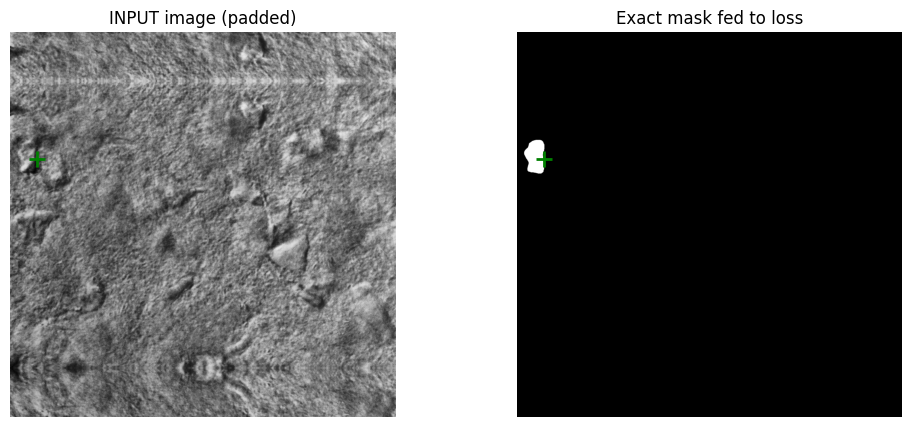

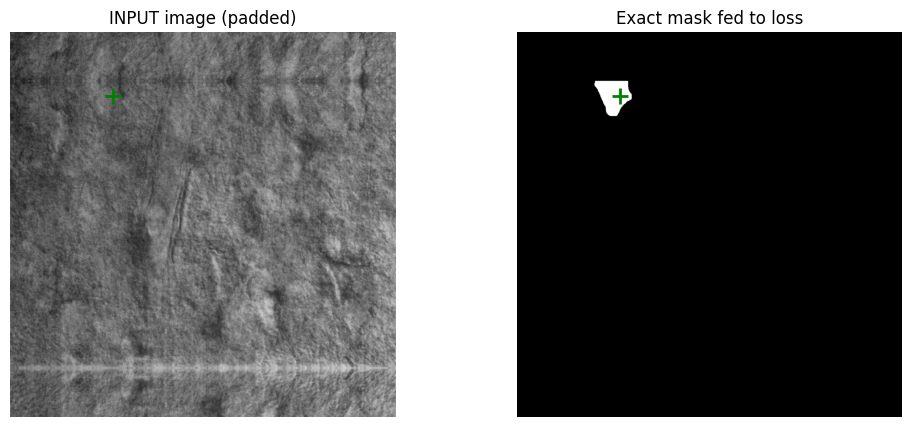

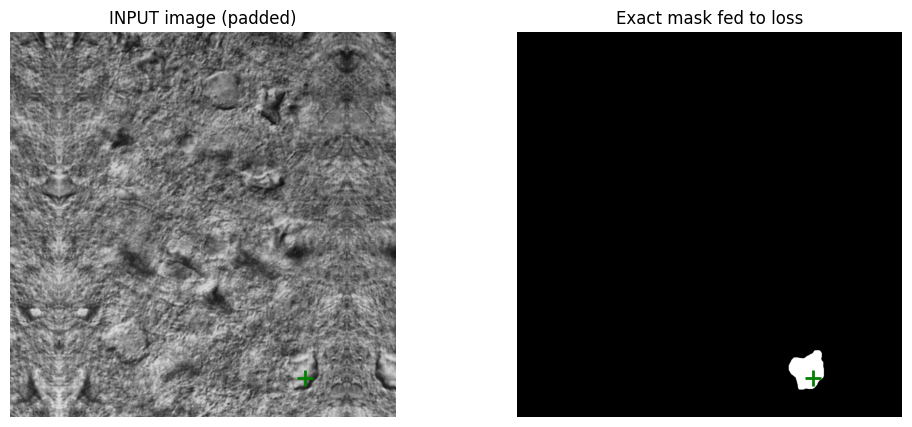

In [19]:
import matplotlib.pyplot as plt
batch = next(iter(train_loader))                # ← один батч
imgs_np = batch["image"]                        # padded np.ndarray
masks   = batch["mask"]                         # (B,1,H,W)
points  = batch["point"]                        # (B,N,2)
labels  = batch["label"]                        # (B,N)

for i in range(3):                              # покажем первые 3 примера
    img = imgs_np[i]
    msk = masks[i,0].cpu().numpy()              # 0/1
    pts = points[i].cpu().numpy()
    lbs = labels[i].cpu().numpy()

    plt.figure(figsize=(12,5))

    # ── входное изображение ─────────────────────────
    plt.subplot(1,2,1)
    plt.imshow(img)
    for (x,y), l in zip(pts, lbs):
        color, mark = ('g','+') if l==1 else ('r','x')
        plt.scatter([x],[y],c=color,marker=mark,s=120,lw=2)
    plt.axis('off'); plt.title("INPUT image (padded)")

    # ── маска 0/1 с фиксированным диапазоном ─────────
    plt.subplot(1,2,2)
    plt.imshow(msk, cmap='gray', vmin=0, vmax=1)   
    for (x,y), l in zip(pts, lbs):
        color, mark = ('g','+') if l==1 else ('r','x')
        plt.scatter([x],[y],c=color,marker=mark,s=120,lw=2)
    plt.axis('off'); plt.title("Exact mask fed to loss")

    plt.show()

In [20]:
def batch_iou(gt, pr):
    inter = (gt * (pr > 0.5)).sum(dim=(1,2))
    union = gt.sum(dim=(1,2)) + (pr > 0.5).sum(dim=(1,2)) - inter
    return inter / (union + 1e-6)

@torch.no_grad()
def evaluate(loader):
    sam2_model.eval()
    val_losses, val_ious = [], []

    for batch in loader:
        if batch is None:
            continue

        imgs_np = batch["image"]
        gt_mask = batch["mask"].to(DEVICE)
        pts, lbs = batch["point"].to(DEVICE), batch["label"].to(DEVICE)

        predictor.set_image_batch(imgs_np)
        with torch.amp.autocast("cuda"):
            sp_emb, dn_emb = predictor.model.sam_prompt_encoder(
                points=(pts, lbs), boxes=None, masks=None)

            hi = [f[-1].unsqueeze(0) for f in predictor._features["high_res_feats"]]
            low_logits, scores, *_ = predictor.model.sam_mask_decoder(
                predictor._features["image_embed"],
                predictor.model.sam_prompt_encoder.get_dense_pe(),
                sp_emb, dn_emb, False, False, hi)

            logits = F.interpolate(low_logits, size=gt_mask.shape[-2:],
                                   mode="bilinear", align_corners=False)[:, 0]

            loss, batch_iou = compute_loss(logits, gt_mask, scores)
            val_losses.append(loss.item())
            val_ious.append(batch_iou.item())

    return float(np.mean(val_losses)), float(np.mean(val_ious))

In [21]:
def compute_loss(logits, gt_mask, scores, beta=0.4):
    """
    logits : (B,H,W) сырые логиты
    gt_mask: (B,1,H,W) ground-truth
    scores : (B,1)  — score-предсказание SAM-а
    """
    bce = F.binary_cross_entropy_with_logits(
        logits, gt_mask.squeeze(1))

    prob = torch.sigmoid(logits)
    inter = (prob * gt_mask.squeeze(1)).sum(dim=(1, 2))
    union = prob.sum(dim=(1, 2)) + gt_mask.squeeze(1).sum(dim=(1, 2))
    dice = 1 - (2 * inter + 1) / (union + 1)          # (B,)

    iou_batch   = inter / (union - inter + 1e-6)
    score_loss  = torch.abs(scores[:, 0] - iou_batch).mean()

    loss = (1 - beta) * bce + beta * dice.mean() + 0.05 * score_loss
    return loss, iou_batch.mean()

In [ ]:
start_epoch, best_iou, bad_epochs = 0, 0.0, 0
if LAST_CKPT.exists():
    ckpt = torch.load(LAST_CKPT, map_location=DEVICE)
    sam2_model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    sched.load_state_dict(ckpt["scheduler"])
    scaler.load_state_dict(ckpt["scaler"])
    start_epoch = ckpt["epoch"] + 1
    best_iou    = ckpt["best_iou"]
    bad_epochs  = ckpt.get("bad_epochs", 0)
    print(f"▶️  Resumed from {LAST_CKPT} (epoch {start_epoch}, best IoU {best_iou:.3f})")
else:
    print("🆕  Starting training from scratch")
def save_ckpt(epoch, is_best=False):
    state = {
        "epoch":      epoch,
        "model":      sam2_model.state_dict(),
        "optimizer":  optimizer.state_dict(),
        "scheduler":  sched.state_dict(),
        "scaler":     scaler.state_dict(),
        "best_iou":   best_iou,
        "bad_epochs": bad_epochs,
    }
    torch.save(state, LAST_CKPT)
    if is_best:
        torch.save(sam2_model.state_dict(), BEST_CKPT)

print(f"⏳  Training for {EPOCHS} epochs "
      f"(from epoch {start_epoch} to {EPOCHS-1})")

for epoch in range(start_epoch, EPOCHS):
    sam2_model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    running_iou = 0.0

    for batch in pbar:
        if batch is None: 
            continue
        imgs_np = batch["image"]
        gt_mask = batch["mask"].to(DEVICE)
        pts, lbs = batch["point"].to(DEVICE), batch["label"].to(DEVICE)

        predictor.set_image_batch(imgs_np)

        with torch.amp.autocast("cuda"):
            sp_emb, dn_emb = predictor.model.sam_prompt_encoder(
                points=(pts, lbs), boxes=None, masks=None)

            hi = [f[-1].unsqueeze(0) for f in predictor._features["high_res_feats"]]
            low_logits, scores, *_ = predictor.model.sam_mask_decoder(
                predictor._features["image_embed"],
                predictor.model.sam_prompt_encoder.get_dense_pe(),
                sp_emb, dn_emb, False, False, hi)

            logits = torch.nn.functional.interpolate(
                low_logits, size=gt_mask.shape[-2:], mode="bilinear", align_corners=False)[:, 0]

            loss, batch_iou = compute_loss(logits, gt_mask, scores)

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        sched.step()

        running_iou = running_iou * 0.99 + 0.01 * batch_iou.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}",
                         train_iou=f"{running_iou:.3f}")

    val_loss, val_iou = evaluate(val_loader)
    print(f"[Epoch {epoch+1}]  val_loss={val_loss:.4f}  val_IoU={val_iou:.3f}")

    improved = val_iou > best_iou
    if improved:
        best_iou, bad_epochs = val_iou, 0
        print(f"  ↑ New best IoU = {best_iou:.3f} → saving BEST checkpoint")
    else:
        bad_epochs += 1

    save_ckpt(epoch, is_best=improved)

    if bad_epochs >= 7:
        print("  ⏹ Early stopping triggered (no improvement 7 epochs).")
        break

print(f"✓ Training finished.  Best IoU = {best_iou:.3f} "
      f" (weights → {BEST_CKPT})")

🆕  Starting training from scratch
⏳  Training for 200 epochs (from epoch 0 to 199)


Epoch 1/200:   0%|          | 0/144 [00:00<?, ?it/s]

/home/miroslavm/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


In [ ]:
import random, torch

sam2_model.eval()                 # eval-mode (отключаем dropout и т.п.)

for idx in random.sample(range(len(val_set)), 3):
    sample = val_set[idx]
    if sample is None:
        continue

    # ---------- вытаскиваем данные ----------
    img_np  = sample["image"]                       # np.ndarray (H,W,3)
    gt_mask = sample["mask"].to(DEVICE)             # (1,H,W)
    pts     = sample["point"].unsqueeze(0).to(DEVICE)   # (1,2,2)   pos,neg
    lbs     = sample["label"].unsqueeze(0).to(DEVICE)   # (1,2)

    # ---------- forward SAM ----------
    predictor.set_image_batch([img_np])
    with torch.no_grad(), torch.amp.autocast("cuda"):
        sp_emb, dn_emb = predictor.model.sam_prompt_encoder(
            points=(pts, lbs), boxes=None, masks=None)

        hi = [f[-1].unsqueeze(0) for f in predictor._features["high_res_feats"]]
        low_logits, _, _, _ = predictor.model.sam_mask_decoder(
            predictor._features["image_embed"],
            predictor.model.sam_prompt_encoder.get_dense_pe(),
            sp_emb, dn_emb, False, False, hi)

        logits_up = torch.nn.functional.interpolate(
            low_logits, size=gt_mask.shape[-2:], mode="bilinear",
            align_corners=False)[:, 0]
        pred_prob = torch.sigmoid(logits_up)[0].cpu().numpy()

    # ---------- координаты точек ----------
    pos_pt = sample["point"][0].cpu().numpy()   # positive
    neg_pt = sample["point"][1].cpu().numpy()   # negative

    # ---------- визуализация ----------
    plt.figure(figsize=(16,4))

    # 1) входное изображение + prompt-ы
    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.scatter([pos_pt[0]], [pos_pt[1]], c='g', marker='+', s=120, lw=2, label='pos')
    plt.scatter([neg_pt[0]], [neg_pt[1]], c='r', marker='x', s=120, lw=2, label='neg')
    plt.legend(loc='upper right'); plt.axis('off'); plt.title("Input (+/− prompts)")

    # 2) GT-маска объекта + prompts
    plt.subplot(1,3,2)
    plt.imshow(gt_mask.squeeze(0).cpu(), cmap='gray')
    plt.scatter([pos_pt[0]], [pos_pt[1]], c='g', marker='+', s=120, lw=2)
    plt.scatter([neg_pt[0]], [neg_pt[1]], c='r', marker='x', s=120, lw=2)
    plt.axis('off'); plt.title("GT object mask")

    # 3) Предсказанная маска
    plt.subplot(1,3,3)
    plt.imshow(pred_prob > 0.5, cmap='gray')
    plt.axis('off'); plt.title("Predicted mask (thr 0.5)")

    plt.show()
